# Experiment 2: Comparison of Separation Radius

This notebook compares the separation radius of different point sets:
- **Korobov lattices** (our method 1)
- **Explicit rank-1 lattices** (our method 2)
- **Random points** (baseline)
- **Halton sequences** (standard QMC)
- **Sobol sequences** (standard QMC)

**Key observation:** Our proposed point sets exhibit separation radius decay of order $N^{-1/d}$, which is optimal for quasi-uniform point sets.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import from lattice_qmc package
from lattice_qmc import KorobovLattice, ExplicitRank1Lattice
from lattice_qmc.utils import generate_primes, compute_separation_radius_fast

# QMCPy for Halton and Sobol
try:
    import qmcpy as qp
    QMCPY_AVAILABLE = True
    print("QMCPy loaded successfully.")
except ImportError:
    QMCPY_AVAILABLE = False
    print("QMCPy not available. Install with: pip install qmcpy")

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.figsize': (10, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

np.random.seed(42)
print("Setup complete!")

QMCPy loaded successfully.
Setup complete!


## Helper Functions for Other Point Sets

In [2]:
def generate_random_points(n: int, d: int, seed: int = None) -> np.ndarray:
    """Generate n random points in [0, 1)^d."""
    if seed is not None:
        np.random.seed(seed)
    return np.random.rand(n, d)


def generate_halton_points(n: int, d: int) -> np.ndarray:
    """Generate n Halton sequence points in [0, 1)^d using QMCPy."""
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy is required for Halton sequences.")
    halton = qp.Halton(d, seed=42)
    return halton.gen_samples(n)


def generate_sobol_points(n: int, d: int) -> np.ndarray:
    """Generate n Sobol sequence points in [0, 1)^d using QMCPy."""
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy is required for Sobol sequences.")
    sobol = qp.Sobol(d, seed=42)
    return sobol.gen_samples(n)


print("Helper functions loaded.")

Helper functions loaded.


---

## Experiment: Separation Radius Comparison

The separation radius is defined as:
$$q(P) = \frac{1}{2} \min_{i \neq j} \|x_i - x_j\|$$

For quasi-uniform point sets, we expect:
$$q(P) \sim N^{-1/d}$$

This means on a log-log plot of $q$ vs $N$, quasi-uniform point sets should show a slope of $-1/d$.

### Test Configurations

In [36]:
# Test dimensions
test_dimensions = [2, 3, 4, 5]

# Korobov: primes
korobov_primes = [11, 23, 47, 101, 199, 401, 797]

# Sobol: powers of 2
sobol_powers = [16, 32, 64, 128, 256, 512, 1024]

# Halton/Random: match roughly with others
halton_random_n = [16, 32, 64, 128, 256, 512, 1024]

# Explicit: m parameter (varies by dimension)
# d=2: m=7, d>=3: m=10
explicit_m_by_d = {2: 7, 3: 12, 4: 12, 5: 10}

print("Test configurations defined.")
print(f"Dimensions: {test_dimensions}")
print(f"Korobov primes: {korobov_primes}")
print(f"Sobol powers of 2: {sobol_powers}")
print(f"Explicit m by dimension: {explicit_m_by_d}")

Test configurations defined.
Dimensions: [2, 3, 4, 5]
Korobov primes: [11, 23, 47, 101, 199, 401, 797]
Sobol powers of 2: [16, 32, 64, 128, 256, 512, 1024]
Explicit m by dimension: {2: 7, 3: 12, 4: 12, 5: 10}


### Compute Separation Radii

In [37]:
def run_separation_radius_experiment(d: int, verbose: bool = True):
    """
    Compute separation radii for all point set types in dimension d.
    Uses the separation_radius() method from lattice classes.
    """
    results = {
        'korobov': {'N': [], 'sep_radius': []},
        'explicit': {'N': [], 'sep_radius': [], 'm': []},
        'random': {'N': [], 'sep_radius': []},
        'halton': {'N': [], 'sep_radius': []},
        'sobol': {'N': [], 'sep_radius': []},
    }
    
    # Get explicit_m for this dimension
    explicit_m = explicit_m_by_d.get(d, 10)
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Dimension d = {d} (explicit_m = {explicit_m})")
        print(f"{'='*60}")
    
    # Korobov lattices - use separation_radius() method
    if verbose:
        print("\nKorobov lattices:")
    for N in korobov_primes:
        lattice = KorobovLattice(d=d, N=N, criterion="product")
        sep_rad = lattice.separation_radius()
        results['korobov']['N'].append(N)
        results['korobov']['sep_radius'].append(sep_rad)
        if verbose:
            print(f"  N = {N}: q = {sep_rad:.6f}")
    
    # Explicit rank-1 lattices - use separation_radius() method
    # Loop over i in range(explicit_m + 1) to get different Q values
    if verbose:
        print("\nExplicit rank-1 lattices:")
    for i in range(explicit_m + 1):
        lattice = ExplicitRank1Lattice(d=d, m=i)
        Q = lattice.Q
        if Q < 10:  # Skip small Q
            continue
        sep_rad = lattice.separation_radius()
        results['explicit']['N'].append(Q)
        results['explicit']['sep_radius'].append(sep_rad)
        results['explicit']['m'].append(i)
        if verbose:
            print(f"  m = {i}: Q = {Q}, q = {sep_rad:.6f}")
    
    # Random points - use compute_separation_radius_fast
    if verbose:
        print("\nRandom points:")
    for n in halton_random_n:
        points = generate_random_points(n, d, seed=42)
        sep_rad = compute_separation_radius_fast(points, toroidal=True)
        results['random']['N'].append(n)
        results['random']['sep_radius'].append(sep_rad)
        if verbose:
            print(f"  N = {n}: q = {sep_rad:.6f}")
    
    # Halton sequence
    if QMCPY_AVAILABLE:
        if verbose:
            print("\nHalton sequence:")
        for n in halton_random_n:
            points = generate_halton_points(n, d)
            sep_rad = compute_separation_radius_fast(points, toroidal=True)
            results['halton']['N'].append(n)
            results['halton']['sep_radius'].append(sep_rad)
            if verbose:
                print(f"  N = {n}: q = {sep_rad:.6f}")
        
        # Sobol sequence
        if verbose:
            print("\nSobol sequence:")
        for n in sobol_powers:
            points = generate_sobol_points(n, d)
            sep_rad = compute_separation_radius_fast(points, toroidal=True)
            results['sobol']['N'].append(n)
            results['sobol']['sep_radius'].append(sep_rad)
            if verbose:
                print(f"  N = {n}: q = {sep_rad:.6f}")
    
    return results

In [38]:
# Run experiments for all dimensions
all_results = {}
for d in test_dimensions:
    all_results[d] = run_separation_radius_experiment(d, verbose=True)


Dimension d = 2 (explicit_m = 7)

Korobov lattices:
  N = 11: q = 0.143740
  N = 23: q = 0.108696
  N = 47: q = 0.075224
  N = 101: q = 0.051685
  N = 199: q = 0.035710
  N = 401: q = 0.025705
  N = 797: q = 0.018800

Explicit rank-1 lattices:
  m = 3: Q = 12, q = 0.131762
  m = 4: Q = 46, q = 0.068745
  m = 5: Q = 177, q = 0.026650
  m = 6: Q = 681, q = 0.017758
  m = 7: Q = 858, q = 0.014095

Random points:
  N = 16: q = 0.015664
  N = 32: q = 0.004409
  N = 64: q = 0.004409
  N = 128: q = 0.001337
  N = 256: q = 0.001337
  N = 512: q = 0.000670
  N = 1024: q = 0.000501

Halton sequence:
  N = 16: q = 0.048994
  N = 32: q = 0.030513
  N = 64: q = 0.020900
  N = 128: q = 0.005868
  N = 256: q = 0.004127
  N = 512: q = 0.002743
  N = 1024: q = 0.002437

Sobol sequence:
  N = 16: q = 0.056354
  N = 32: q = 0.035759
  N = 64: q = 0.007269
  N = 128: q = 0.007269
  N = 256: q = 0.007269
  N = 512: q = 0.002769
  N = 1024: q = 0.002183

Dimension d = 3 (explicit_m = 12)

Korobov lattices:

### Plot Results


Figures saved as 'separation_radius_comparison.pdf' and '.png'


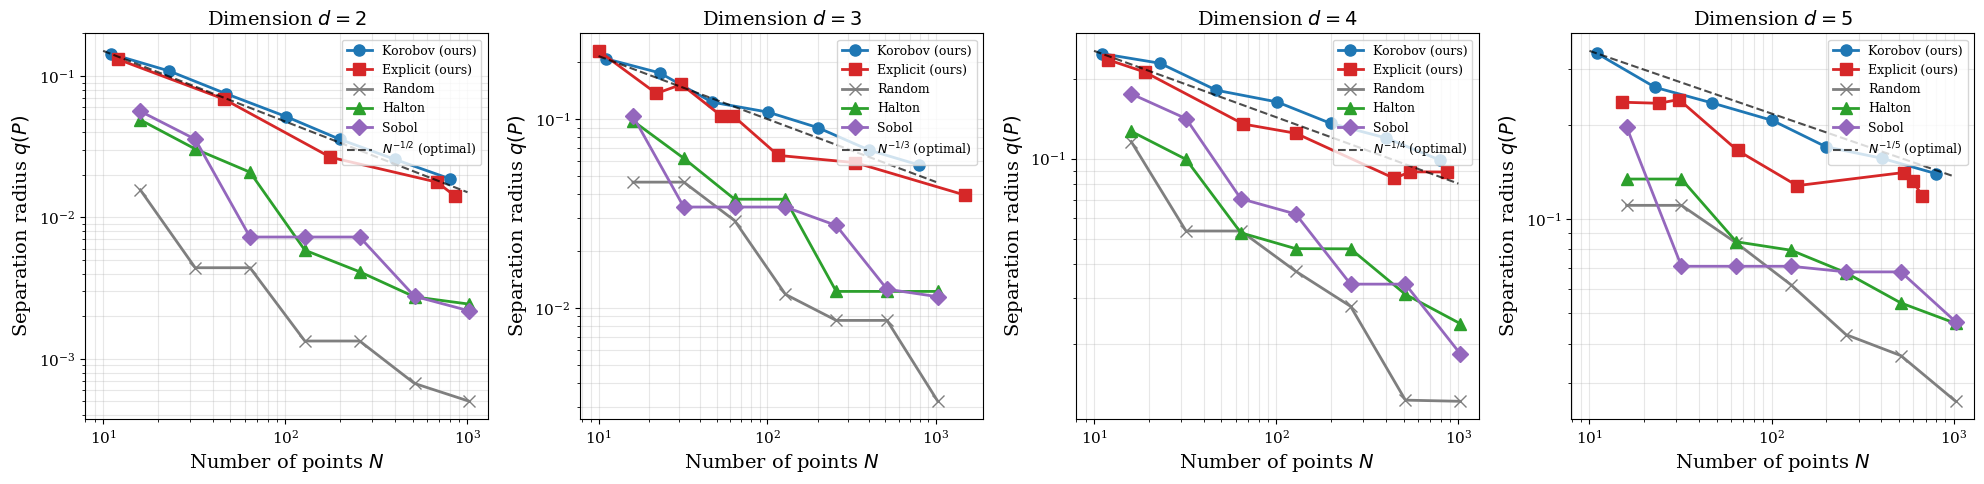

In [39]:
def plot_separation_radius_comparison(all_results: dict, save_fig: bool = True):
    """
    Create publication-quality plots of separation radius vs N.
    """
    n_dims = len(all_results)
    fig, axes = plt.subplots(1, n_dims, figsize=(5*n_dims, 5))
    if n_dims == 1:
        axes = [axes]
    
    # Colors and markers for each method
    styles = {
        'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
        'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
        'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
        'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
        'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
    }
    
    for idx, (d, results) in enumerate(all_results.items()):
        ax = axes[idx]
        
        # Plot each method
        for method, style in styles.items():
            if results[method]['N']:
                ax.loglog(results[method]['N'], results[method]['sep_radius'],
                         marker=style['marker'], color=style['color'],
                         label=style['label'], linewidth=2, markersize=8)
        
        # Add reference line for N^{-1/d}
        N_ref = np.array([10, 1000])
        scale = results['korobov']['sep_radius'][0] * (results['korobov']['N'][0] ** (1/d))
        q_ref = scale * N_ref ** (-1/d)
        ax.loglog(N_ref, q_ref, 'k--', linewidth=1.5, alpha=0.7,
                 label=f'$N^{{-1/{d}}}$ (optimal)')
        
        ax.set_xlabel('Number of points $N$')
        ax.set_ylabel('Separation radius $q(P)$')
        ax.set_title(f'Dimension $d = {d}$')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('separation_radius_comparison.pdf')
        plt.savefig('separation_radius_comparison.png', dpi=300)
        print("\nFigures saved as 'separation_radius_comparison.pdf' and '.png'")
    
    plt.show()


plot_separation_radius_comparison(all_results)

### Compute and Compare Decay Rates

In [40]:
def compute_decay_rate(N_vals, sep_radius_vals):
    """
    Estimate the decay rate by fitting log(q) = a + b*log(N).
    Returns b (the decay exponent).
    """
    if len(N_vals) < 2:
        return np.nan
    log_N = np.log(np.array(N_vals))
    log_q = np.log(np.array(sep_radius_vals))
    coeffs = np.polyfit(log_N, log_q, 1)
    return coeffs[0]


print("\n" + "="*80)
print("DECAY RATE ANALYSIS")
print("Expected: -1/d for quasi-uniform point sets")
print("="*80)

for d in test_dimensions:
    results = all_results[d]
    expected_rate = -1/d
    
    print(f"\nDimension d = {d} (expected rate: {expected_rate:.4f})")
    print("-" * 50)
    
    for method in ['korobov', 'explicit', 'random', 'halton', 'sobol']:
        if results[method]['N']:
            rate = compute_decay_rate(results[method]['N'], results[method]['sep_radius'])
            deviation = abs(rate - expected_rate)
            match = "✓" if deviation < 0.1 else "✗"
            print(f"  {method:10s}: rate = {rate:+.4f}  (deviation: {deviation:.4f}) {match}")


DECAY RATE ANALYSIS
Expected: -1/d for quasi-uniform point sets

Dimension d = 2 (expected rate: -0.5000)
--------------------------------------------------
  korobov   : rate = -0.4863  (deviation: 0.0137) ✓
  explicit  : rate = -0.5181  (deviation: 0.0181) ✓
  random    : rate = -0.7879  (deviation: 0.2879) ✗
  halton    : rate = -0.7957  (deviation: 0.2957) ✗
  sobol     : rate = -0.7662  (deviation: 0.2662) ✗

Dimension d = 3 (expected rate: -0.3333)
--------------------------------------------------
  korobov   : rate = -0.3041  (deviation: 0.0293) ✓
  explicit  : rate = -0.3479  (deviation: 0.0146) ✓
  random    : rate = -0.6492  (deviation: 0.3159) ✗
  halton    : rate = -0.5463  (deviation: 0.2129) ✗
  sobol     : rate = -0.4549  (deviation: 0.1215) ✗

Dimension d = 4 (expected rate: -0.2500)
--------------------------------------------------
  korobov   : rate = -0.2177  (deviation: 0.0323) ✓
  explicit  : rate = -0.2464  (deviation: 0.0036) ✓
  random    : rate = -0.5331  (d